In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.layers import Input, Dense, Conv2D, Flatten
from keras.models import Model, Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])        
    return X

### Data Load
- 'PL04496-03040' (prod_list[0]) 제품만을 대상으로
- 정상 데이터만으로 학습
- 전체 데이터로 테스트

In [5]:
isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv')
prod_list = isee_machine.ProductNum.unique()

# prod_list[0] 제품에 대해서만 분석
isee_machine = isee_machine[isee_machine.ProductNum == prod_list[0]]    

analy_col = ['CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4'] 
isee_machine['NG_Label'] = isee_machine['NG'] + isee_machine['NG5']

# # combined_label== 1인것을 정상으로 편입, 하나씩 낮춰줌
# isee_machine['combined_label'] = [x-1 if x>1 else x for x in isee_machine['combined_label']] 
# # 원래 combined_label== 3,4,5 인 것을 위험군으로 합침
# isee_machine['combined_label'] = [2 if x>=2 else x for x in isee_machine['combined_label']]

# combined_label에서 lof_label 빼고, svm_label 넣기
isee_machine['combined_label'] = isee_machine['K_mahala_label'] + isee_machine['mahala_label'] + isee_machine['gmm_label'] +isee_machine['IF_label']

# 원래 combined_label== 1,2,3,4,5 인 것을 위험군으로 합침
isee_machine['combined_label'] = [1 if x>=3 else 0 for x in isee_machine['combined_label']]

In [6]:
temp = []
n = 0
ng_list = isee_machine[isee_machine['NG']==1].index

while n in range(len(isee_machine)):
    if n in ng_list: 
        for _ in range(0,11):
            temp.append(1)
        n+= 11
    else: 
        temp.append(0)
        n += 1
        
isee_machine['ng_after']= temp

- prop: 이상 비율 설정 (0.05876542354082906)

In [7]:
prop = isee_machine['NG'].sum()/len(isee_machine)

- input 데이터 셋 생성

In [10]:
w=10    # window size
s=2     # stride

X = []
label = []
target_label = 'combined_label'

for c in isee_machine['CycleNum'].unique():
    df = isee_machine[isee_machine['CycleNum']==c]
    df = df.reset_index(drop=True)
    temp_cnt= int((len(df)-w)/s)
    for i in range(temp_cnt):
        temp_df = df.loc[s*i:s*i+w-1]
        X.append(temp_df[analy_col].values)
        label.append((temp_df[target_label]**2).sum())

X = np.array(X)
np.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [12]:
label_df = pd.DataFrame(label, columns=['w_label'])
label_df['w_label'] = label_df.w_label.astype(int)

In [13]:
normal_idx = label_df[(label_df.w_label ==0)].index.tolist()
test_idx = label_df[(label_df.w_label >=0)].index.tolist()

X_train = X[normal_idx]
X_test = X[test_idx]

print("정상 데이터 수: ",len(normal_idx), " 전체 데이터 수 :", len(test_idx))

정상 데이터 수:  26457  전체 데이터 수 : 28591


In [14]:
prop = 1 - (len(normal_idx) / len(test_idx))
prop

0.07463887237242484

- scale

In [15]:
# 정상 데이터로만 scale
# Initialize a scaler using the training data.
scaler = MinMaxScaler().fit(flatten(X_train))

scaled_train = scale(X_train, scaler)

# 전체 데이터로 테스트
scaled_X = scale(X_test, scaler)

In [16]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Dropout, RepeatVector
from keras.utils import plot_model

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

input_data = Input(shape=X_train.shape[1:])
x = LSTM(units=8, activation='relu', input_shape = (timesteps, n_features), return_sequences=True)(input_data)
x = LSTM(units=4, activation='relu', return_sequences=True)(x)
#x = RepeatVector(timesteps)(x)

x = LSTM(units=4, activation='relu', return_sequences=True)(x)
x = LSTM(units=8, activation='relu', return_sequences=True)(x)
decoded = TimeDistributed(Dense(units=n_features))(x)

autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

### fit model
autoencoder.fit(scaled_train, scaled_train, epochs= 10, batch_size=128, shuffle=True, verbose=1)
autoencoder.summary()

Epoch 1/10
26457/26457 [==============================] - 7s 276us/step - loss: 0.1801
Epoch 2/10
26457/26457 [==============================] - 4s 165us/step - loss: 0.0953
Epoch 3/10
26457/26457 [==============================] - 4s 165us/step - loss: 0.0556
Epoch 4/10
26457/26457 [==============================] - 4s 165us/step - loss: 0.0383 0s - loss: 0.
Epoch 5/10
26457/26457 [==============================] - 5s 170us/step - loss: 0.0313
Epoch 6/10
26457/26457 [==============================] - 5s 174us/step - loss: 0.0286
Epoch 7/10
26457/26457 [==============================] - 5s 179us/step - loss: 0.0276
Epoch 8/10
26457/26457 [==============================] - 5s 192us/step - loss: 0.0272
Epoch 9/10
26457/26457 [==============================] - 6s 219us/step - loss: 0.0271 0s - loss: 0.027
Epoch 10/10
26457/26457 [==============================] - 5s 184us/step - loss: 0.0271
_________________________________________________________________
Layer (type)                 Out

In [17]:
# demonstrate recreation
lstm_predict = autoencoder.predict(scaled_X)

lstm_predict = lstm_predict.reshape(lstm_predict.shape[0], lstm_predict.shape[1]* lstm_predict.shape[2])
X2 = scaled_X.reshape(scaled_X.shape[0], scaled_X.shape[1]* scaled_X.shape[2])

In [18]:
### calculate MSE
temp_df = pd.DataFrame(mean_squared_error(X2.T, lstm_predict.T, multioutput='raw_values'), columns=['mse'])
temp_df = pd.concat([temp_df,label_df.loc[test_idx].reset_index(drop=True)], axis=1)

In [20]:
temp_df.w_label.unique()

array([ 0,  1,  2,  3, 10,  9,  7,  5,  4,  6,  8], dtype=int64)

In [22]:
div = temp_df.w_label.max()/4
temp_df['w_label'] = np.round(temp_df.w_label/div).astype(int)

In [23]:
k = sorted(temp_df.mse.values, reverse=True)
t = np.ceil(len(temp_df.mse.values) * prop).astype(int)

lstmAE_label = []
t4 = len(temp_df[temp_df.w_label==4])
t3 = len(temp_df[temp_df.w_label>=3])
t2 = len(temp_df[temp_df.w_label>=2])
t1 = len(temp_df[temp_df.w_label>=1])

for x in temp_df.mse.values:
    if x >= k[t4]: lstmAE_label.append(4)
    elif x < k[t4] and x >= k[t3]: lstmAE_label.append(3)
    elif x < k[t3] and x >= k[t2]: lstmAE_label.append(2)
    elif x < k[t2] and x >= k[t1]: lstmAE_label.append(1)
    else: lstmAE_label.append(0)
    

temp_df['lstmAE_label'] = lstmAE_label

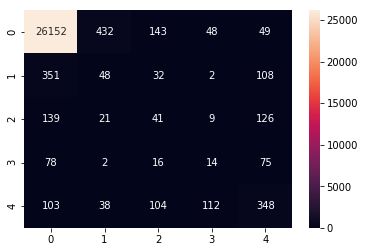

In [24]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

#y = [0 if x in [0,2] else x for x in temp_df.risk_label]

df_cm = confusion_matrix(temp_df.w_label, temp_df.lstmAE_label)
sn.heatmap(df_cm, annot=True, fmt='d')

In [140]:
print(classification_report(temp_df.label0, temp_df.lstmAE_label))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     16907
           4       0.44      0.44      0.44     11184

   micro avg       0.55      0.55      0.55     28091
   macro avg       0.53      0.53      0.53     28091
weighted avg       0.55      0.55      0.55     28091



In [25]:
temp_df.groupby(['lstmAE_label'])[['mse']].describe().T

lstmAE_label             0           1           2           3           4
mse count     26823.000000  541.000000  336.000000  185.000000  706.000000
    mean          0.026645    0.061667    0.071166    0.077307    0.193721
    std           0.011980    0.001261    0.003784    0.000919    0.274640
    min           0.005036    0.059934    0.064861    0.075845    0.079135
    25%           0.018717    0.060549    0.067071    0.076438    0.092078
    50%           0.023765    0.061562    0.071915    0.077272    0.105209
    75%           0.032735    0.062553    0.074815    0.078107    0.184667
    max           0.059934    0.064841    0.075842    0.079114    2.787345

In [32]:
X.mean(axis=1).shape

(28591, 17)

In [38]:
temp_concat = pd.concat([temp_df,pd.DataFrame(X.mean(axis=1),columns=analy_col)], axis=1)

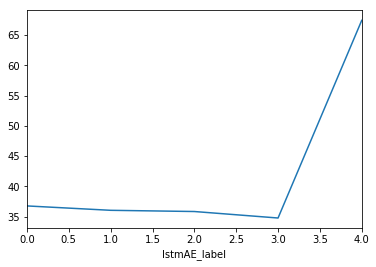

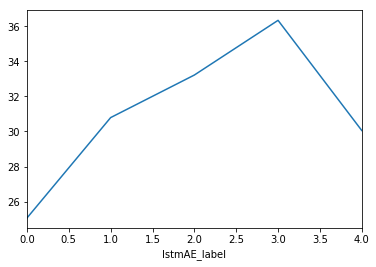

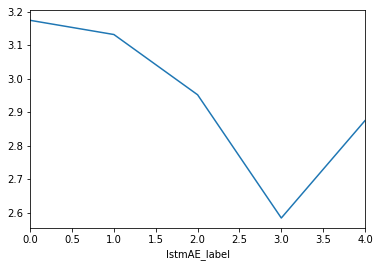

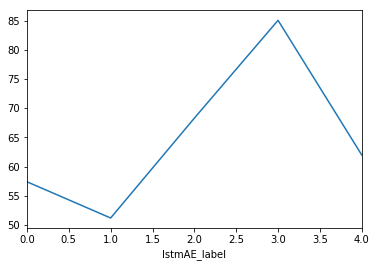

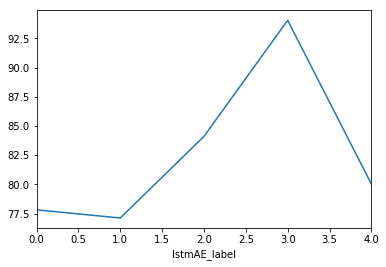

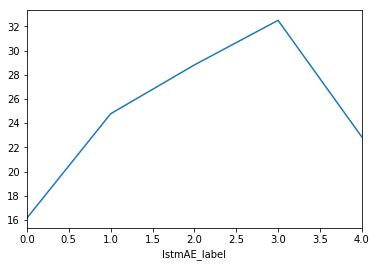

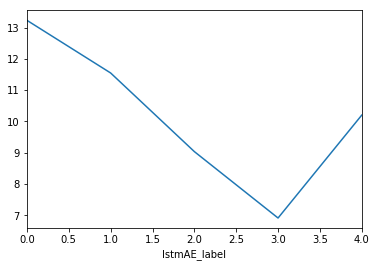

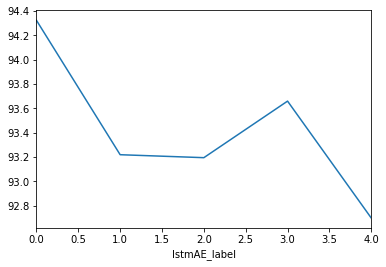

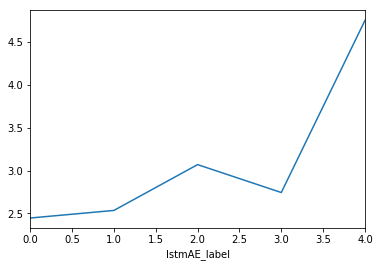

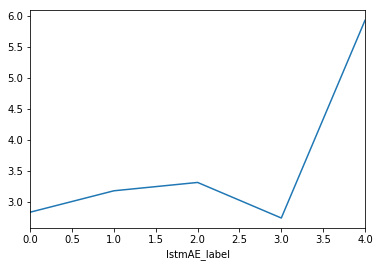

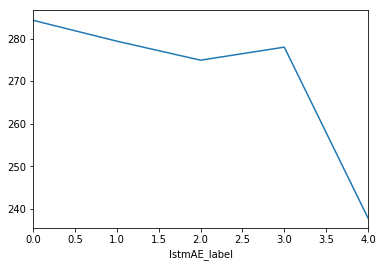

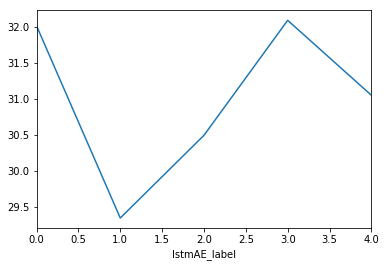

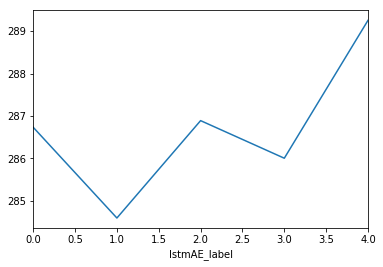

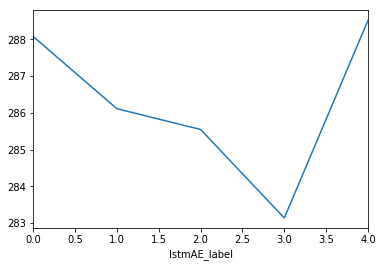

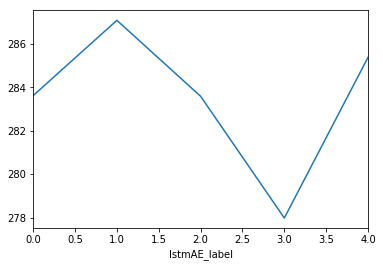

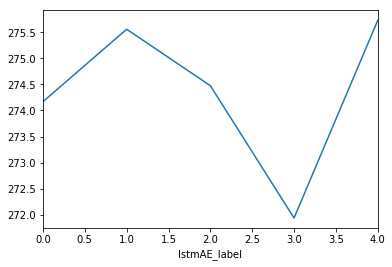

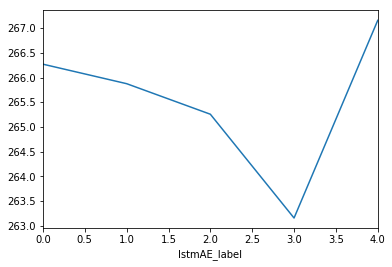

In [45]:
for i in range(len(analy_col)):
    temp_concat.groupby(['lstmAE_label'])[analy_col[i]].mean().plot()
    plt.show()